In [1]:
import pandas as pd


df = pd.read_csv('SMILES_Big_Data_Set.csv')
smiles_list = df['SMILES'].tolist()  # Предполагаем, что столбец называется 'SMILES'
print(f"Всего молекул: {len(smiles_list)}")

Всего молекул: 16087


In [3]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 21.3 MB/s eta 0:00:00


In [4]:
from rdkit import Chem

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

smiles_list = [s.replace('Br', 'R').replace('Cl', 'L') for s in smiles_list]
all_chars = sorted(list(set(''.join(smiles_list))))
all_chars = sorted(set(all_chars) | {'К', 'Н'})
char2idx = {ch: i+1 for i, ch in enumerate(all_chars)}  # 0 — паддинг
idx2char = {i: ch for ch, i in char2idx.items()}
vocab_size = len(char2idx) + 1

def smiles_to_tensor(smiles):
    smiles = 'Н' + smiles + 'К'
    return torch.tensor([char2idx[ch] for ch in smiles], dtype=torch.long)

class SMILESDataset(Dataset):
    def __init__(self, smiles_list):
        self.data = [smiles_to_tensor(s) for s in smiles_list]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return x, y

def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    x_batch = pad_sequence(x_batch, batch_first=True)
    y_batch = pad_sequence(y_batch, batch_first=True)
    return x_batch, y_batch

dataset = SMILESDataset(smiles_list)
loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


In [17]:
import torch.nn as nn

class SMILESLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        return self.fc(x)

In [18]:
import matplotlib.pyplot as plt

loss_history = []

In [19]:
model = SMILESLSTM(vocab_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=0.001,
    alpha=0.9,
    momentum=0.0,
    eps=1e-7,
    centered=False
)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(16):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= (len(x) * 16)
    print(f"Эпоха {epoch + 1}: Потеря = {total_loss:.4f}")
    loss_history.append(total_loss)


Эпоха 1: Потеря = 4.6427
Эпоха 2: Потеря = 3.2108
Эпоха 3: Потеря = 2.8613
Эпоха 4: Потеря = 2.6638
Эпоха 5: Потеря = 2.5196
Эпоха 6: Потеря = 2.4101
Эпоха 7: Потеря = 2.3198
Эпоха 8: Потеря = 2.2625
Эпоха 9: Потеря = 2.2146
Эпоха 10: Потеря = 2.1782
Эпоха 11: Потеря = 2.1179
Эпоха 12: Потеря = 2.1126
Эпоха 13: Потеря = 2.0719
Эпоха 14: Потеря = 2.0309
Эпоха 15: Потеря = 2.0346
Эпоха 16: Потеря = 2.0066


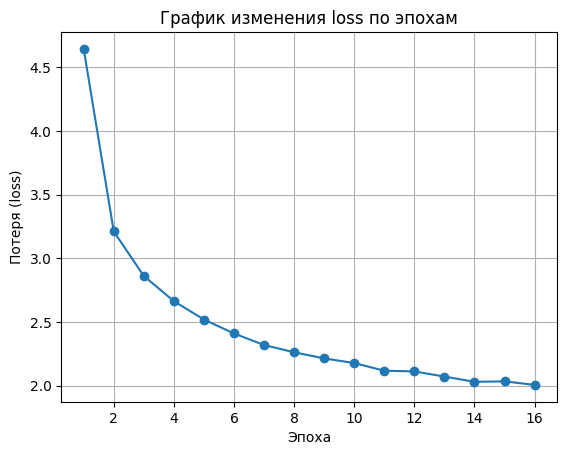

In [20]:
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Потеря (loss)')
plt.title('График изменения loss по эпохам')
plt.grid(True)
plt.show()

In [21]:
from rdkit import Chem

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None


In [28]:
import random
max_len = max(len(s) for s in smiles_list)
def generate_smiles(model, start_token='Н'):
    model.eval()
    input_seq = torch.tensor([[char2idx.get(start_token, 1)]], dtype=torch.long).to(device)
    generated = []
    for i in range(max_len):
        output = model(input_seq)
        logits = output[0, -1]

        logits = logits / 0.75
        probs = torch.softmax(logits, dim=0)
        next_idx = torch.multinomial(probs, num_samples=1).item()

        if next_idx == 0:
            continue
        if next_idx == char2idx['К']:
            break

        next_char = idx2char[next_idx]
        generated.append(next_char)

        input_seq = torch.tensor([[next_idx]], dtype=torch.long).to(device)
    generated = ['Br' if c == 'R' else 'Cl' if c == 'L' else c for c in generated]
    return ''.join(generated)

print(generate_smiles(model))


CC(CC(F)c1


In [33]:
def generate_n_valid_smiles(model, n=100, max_total_tries = 25000):
    valid_smiles = list()
    tries = 0

    while len(valid_smiles) < n and tries < max_total_tries:
        smiles = generate_smiles(
            model
        )
        tries += 1
        if is_valid_smiles(smiles):
            valid_smiles.append(smiles)

    return list(valid_smiles)


In [34]:
valid_molecules = generate_n_valid_smiles(model, n=100)
print(f"Сгенерировано валидных молекул: {len(valid_molecules)}")

Streaming output truncated to the last 5000 lines.
[22:55:42] SMILES Parse Error: extra open parentheses while parsing: CCC(CC(F)c1
[22:55:42] SMILES Parse Error: check for mistakes around position 4:
[22:55:42] CCC(CC(F)c1
[22:55:42] ~~~^
[22:55:42] SMILES Parse Error: Failed parsing SMILES 'CCC(CC(F)c1' for input: 'CCC(CC(F)c1'
[22:55:42] SMILES Parse Error: unclosed ring for input: 'C(F)n1'
[22:55:42] SMILES Parse Error: unclosed ring for input: 'C1'
[22:55:42] SMILES Parse Error: unclosed ring for input: 'C(F)c1'
[22:55:42] SMILES Parse Error: unclosed ring for input: 'CN=CCC(F)c1'
[22:55:42] SMILES Parse Error: extra open parentheses while parsing: C(CC(CC#No1
[22:55:42] SMILES Parse Error: check for mistakes around position 2:
[22:55:42] C(CC(CC#No1
[22:55:42] ~^
[22:55:42] SMILES Parse Error: extra open parentheses while parsing: C(CC(CC#No1
[22:55:42] SMILES Parse Error: check for mistakes around position 5:
[22:55:42] C(CC(CC#No1
[22:55:42] ~~~~^
[22:55:42] SMILES Parse Error:

Сгенерировано валидных молекул: 100


[22:55:54] SMILES Parse Error: extra open parentheses while parsing: CC(C(C(F)c1
[22:55:54] SMILES Parse Error: check for mistakes around position 3:
[22:55:54] CC(C(C(F)c1
[22:55:54] ~~^
[22:55:54] SMILES Parse Error: extra open parentheses while parsing: CC(C(C(F)c1
[22:55:54] SMILES Parse Error: check for mistakes around position 5:
[22:55:54] CC(C(C(F)c1
[22:55:54] ~~~~^
[22:55:54] SMILES Parse Error: Failed parsing SMILES 'CC(C(C(F)c1' for input: 'CC(C(C(F)c1'
[22:55:54] SMILES Parse Error: extra open parentheses while parsing: CN=C(CN=Oc1
[22:55:54] SMILES Parse Error: check for mistakes around position 5:
[22:55:54] CN=C(CN=Oc1
[22:55:54] ~~~~^
[22:55:54] SMILES Parse Error: Failed parsing SMILES 'CN=C(CN=Oc1' for input: 'CN=C(CN=Oc1'
[22:55:54] SMILES Parse Error: unclosed ring for input: 'CC(F)c1'
[22:55:54] SMILES Parse Error: unclosed ring for input: 'C#N=C1'
[22:55:54] SMILES Parse Error: unclosed ring for input: 'C(F)c1'


In [35]:
for i, smi in enumerate(valid_molecules[:100]):
    print(f"{i+1}: {smi}")

1: Cc1CCCc1
2: CNC(CC(F)c1)c1
3: Cc1CCCc1
4: OCCCc1CCCC(F)c1
5: Oc1Cc1
6: Oc1COCCC1
7: C(F)c1C(F)c1
8: CC(F)c1CCCC(F)c1
9: OCC(CC(F)c1)c1
10: COCCOCCCC(Cl)c1CC(F)c1
11: C
12: C(CCc1)c1
13: CC(CCNCC(F)c1)c1
14: C(F)c1CCC(F)c1
15: Cc1Cc1
16: C(C(F)c1)c1
17: CO
18: C(F)c1CCC(Cl)c1
19: CCCc1C(F)c1
20: N=CBr
21: CCC(F)c1S(F)c1
22: Cc1CCc1
23: CBr
24: CCN=C
25: COCC(F)c1Oc1
26: C(C(F)c1)c1
27: O
28: CC1C(F)c1
29: CCC(Cc1)n1
30: Cc1Cc1
31: CI
32: CC(CCC(Cl)c1)c1
33: CCC(F)c1C(Cl)n1
34: C(C(F)c1)c1
35: CC1C(Cl)n1
36: N=O
37: CCC(COC(F)c1)c1
38: N=CCC(C(F)c1)c1
39: CC(F)c1C(F)c1
40: CO
41: C(C(F)n1)c1
42: C1Cc1
43: Cc1C(F)c1
44: CBr
45: C(F)c1CCC(F)c1
46: O
47: C(C(CF)c1)c1
48: CCCOc1CCCC(Cl)c1
49: Cc1C(F)c1
50: N(C1)c1
51: OCN=O
52: C(C(F)n1)c1
53: C(CON=Cc1)n1
54: C(F)c1CCCCCc1
55: Oc1COC(F)n1
56: Cl
57: C(F)c1N=CCN=C(F)c1
58: C(C)c1CCNCCc1
59: CCC(F)c1CC(F)c1
60: Cl
61: C(C(F)c1)c1
62: CCOC
63: CCO
64: CCC1COc1
65: Cc1C(F)c1
66: OCCN=O
67: C(CCCc1)c1
68: CO
69: CCOCN=N
70: Cc1CCCN1
71: C(C(F

In [36]:
torch.save(model.state_dict(), 'smiles_lstm.pth')


In [6]:
vocab_size

36

In [4]:
all_chars = sorted(list(set(''.join(smiles_list))))

In [7]:
all_chars

['#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '=',
 'A',
 'B',
 'C',
 'F',
 'H',
 'I',
 'L',
 'N',
 'O',
 'P',
 'R',
 'S',
 '[',
 ']',
 'c',
 'e',
 'i',
 'n',
 'o',
 's']

In [40]:
char2idx = {ch: i+1 for i, ch in enumerate(all_chars)}  # 0 — паддинг

In [8]:
char2idx

{'#': 1,
 '(': 2,
 ')': 3,
 '+': 4,
 '-': 5,
 '1': 6,
 '2': 7,
 '3': 8,
 '4': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '=': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'F': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'N': 21,
 'O': 22,
 'P': 23,
 'R': 24,
 'S': 25,
 '[': 26,
 ']': 27,
 'c': 28,
 'e': 29,
 'i': 30,
 'n': 31,
 'o': 32,
 's': 33,
 'К': 34,
 'Н': 35}

In [42]:
idx2char = {i: ch for ch, i in char2idx.items()}

In [9]:
idx2char

{1: '#',
 2: '(',
 3: ')',
 4: '+',
 5: '-',
 6: '1',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '=',
 14: 'A',
 15: 'B',
 16: 'C',
 17: 'F',
 18: 'H',
 19: 'I',
 20: 'L',
 21: 'N',
 22: 'O',
 23: 'P',
 24: 'R',
 25: 'S',
 26: '[',
 27: ']',
 28: 'c',
 29: 'e',
 30: 'i',
 31: 'n',
 32: 'o',
 33: 's',
 34: 'К',
 35: 'Н'}

In [44]:
vocab_size = len(char2idx) + 1

In [45]:
vocab_size

34